In [1]:
# import packages
import datetime
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.regularizers import l2, l1
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


2024-12-17 10:40:42.651669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734428442.672105  630091 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734428442.678313  630091 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 10:40:42.699313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# azz

In [81]:
df = pd.read_csv('faults.csv')
df.columns = map(str.lower, df.columns)
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']
enc_dict = {'pastry' : 0,
            'z_scratch' : 1,
            'k_scatch' : 2,
            'stains' : 3,
            'dirtiness' : 4,
            'bumps' : 5,
            'other_faults' : 6}
df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
sm = SMOTE()
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)
sc = StandardScaler()
nonbin_norm = sc.fit_transform(df_nonbin)
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum', 'typeofsteel_a400'], axis = 1, inplace = True)
df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)
df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)
df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)
df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)
df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)

# DAJE

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.1404 - val_loss: 0.7288
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1011 - val_loss: 0.7086
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.0675 - val_loss: 0.6867
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.0340 - val_loss: 0.6610
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.9986 - val_loss: 0.6322
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.9615 - val_loss: 0.6011
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.9232 - val_loss: 0.5684
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.8851 - val_loss: 0.5362
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8490 - val_loss: 0.5071
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8171 - val_loss: 0.4839
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.7917 - val_loss: 0.4686
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7732 - val_los

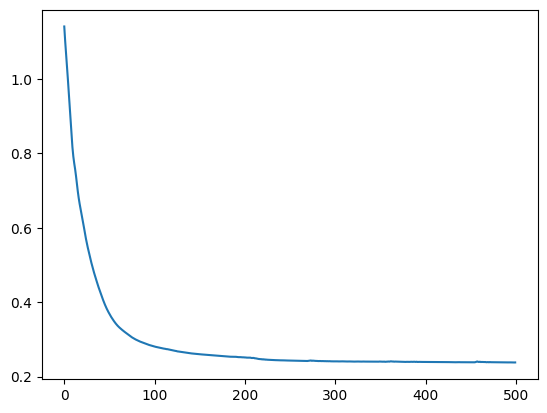

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fitting 5 folds for each of 25 candidates, totalling 125 fits


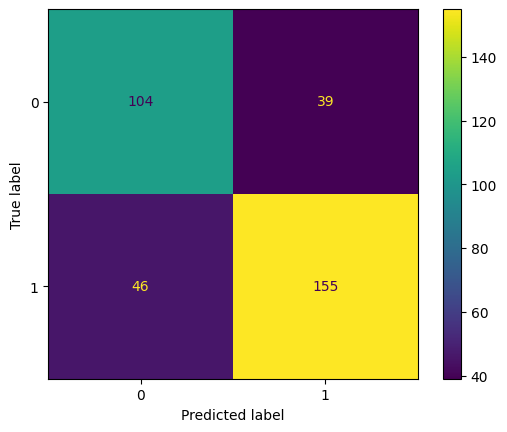

Accuracy score for SVM: 0.75%


In [304]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(256, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

## decoding part
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

df_norm = df_norm[df_norm['anomaly'] >= 5]

#y = tf.keras.utils.to_categorical(y)

x_5, x_6 = X[y == 5], X[y == 6]

history = autoencoder.fit(x_5[0:200], x_5[0:200], 
                batch_size = 256, epochs = 200, 
                shuffle = True, validation_split = 0.20)

plt.plot(history.history['loss'])
plt.show()

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])

cinque_hid_rep = hidden_representation.predict(x_5[:473])
sei_hid_rep = hidden_representation.predict(x_6)

rep_x = np.append(cinque_hid_rep, sei_hid_rep, axis = 0)
y_n = np.zeros(cinque_hid_rep.shape[0])
y_n[y_n == 0] = 5
y_f = np.ones(sei_hid_rep.shape[0])
y_f[y_f == 1] = 6
rep_y = np.append(y_n, y_f)

rep_y = pd.DataFrame(rep_y)
rep_x = pd.DataFrame(rep_x)

X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size = 0.3, random_state = 2)

parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

svc = SVC()

clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

matplotlib.use('inline')
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for SVM: {svm_accuracy}%')

# DAJE 2

In [82]:
df_norm = df_norm.sample(frac = 1)

In [122]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [130]:
# Input layer
input_layer = Input(shape=(X.shape[1],))

# Encoder: trasformazione verso lo spazio latente
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)

# Decoder: ricostruzione dei dati
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

# Classifier: predizione della classe
output_classification = Dense(7, activation = 'softmax', name = "classification")(encoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
classification = Model(inputs = input_layer, outputs = output_classification)

# Compile the model with a combined loss
autoencoder.compile(
    optimizer='adam',
    loss={
        "reconstruction": "mse",
        "classification": "sparse_categorical_crossentropy"
    },
    loss_weights={"reconstruction": 0.5, "classification": 0.5},
    metrics = ['mse', 'accuracy']
)

# Train the autoencoder
history = autoencoder.fit(
    X_train, [X_train, y_train],  # Input: X, Outputs: [reconstruction, classification]
    batch_size=256,
    epochs=100,
    shuffle=False
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - classification_accuracy: 0.4478 - classification_loss: 1.5821 - loss: 1.2057 - reconstruction_loss: 0.8285 - reconstruction_mse: 0.8288
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - classification_accuracy: 0.7772 - classification_loss: 0.6896 - loss: 0.6446 - reconstruction_loss: 0.5994 - reconstruction_mse: 0.5995
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - classification_accuracy: 0.8216 - classification_loss: 0.5181 - loss: 0.5190 - reconstruction_loss: 0.5199 - reconstruction_mse: 0.5199
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - classification_accuracy: 0.8424 - classification_loss: 0.4511 - loss: 0.4710 - reconstruction_loss: 0.4909 - reconstruction_mse: 0.4909
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - classification_accuracy: 0.8555 - classification_loss: 0.4111 - loss: 0.4464 - reconstruction_loss: 0.4816 - reconstruction_mse: 0.4817
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - c

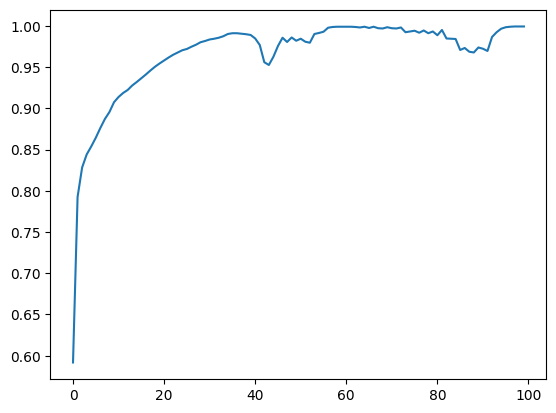

In [131]:
plt.plot(history.history['classification_accuracy'])
plt.show()

In [132]:
# Define encoder model to extract latent features
encoder = Model(inputs = autoencoder.input, outputs = encoded)

# Generate latent representations
latent_features = encoder.predict(X_train)
latent_features_test = encoder.predict(X_test)
latent_features = sc.fit_transform(latent_features)
latent_features_test = sc.fit_transform(latent_features_test)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [133]:
y_pred = classification.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
round(accuracy_score(y_test, y_pred), 2)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.91

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy of SVM: 0.9%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       204
           1       0.94      0.98      0.96       174
           2       0.97      0.96      0.97       212
           3       1.00      1.00      1.00       202
           4       0.98      0.99      0.98       198
           5       0.77      0.83      0.80       206
           6       0.80      0.64      0.71       218

    accuracy                           0.90      1414
   macro avg       0.90      0.91      0.90      1414
weighted avg       0.90      0.90      0.90      1414



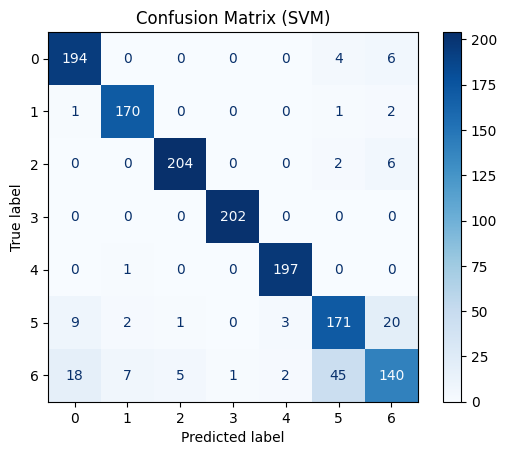

In [134]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train SVM
svc = SVC(kernel='rbf', C = 1, gamma = 0.01)
svc.fit(latent_features, y_train)

# Predict on test set
y_pred = svc.predict(latent_features_test)

# Evaluate SVM
svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f"Accuracy of SVM: {svm_accuracy}%")

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svc.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (SVM)")
plt.show()